In [1]:
import os
import pandas as pd  
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Creating directory to store dataset
if not os.path.isdir("../data/transport"):
    os.makedirs("../data/transport")

In [ ]:
# Download the raw .csv data by copying the data from a cloud storage bucket.
!gsutil cp gs://cloud-training-demos/feat_eng/transport/untidy_vehicle_data.csv ../data/transport

### Read Dataset into a Pandas DataFrame

In [3]:
df_transport = pd.read_csv('../data/transport/untidy_vehicle_data.csv',parse_dates=['Date'])

# Output the first five rows.
df_transport.head() 

,Date,Zip Code,Model Year,Fuel,Make,Light_Duty,Vehicles
0,2018-10-01,90000,2006,Gasoline,OTHER/UNK,NaN,1.0
1,2018-10-01,NaN,2014,Gasoline,NaN,Yes,1.0
2,NaT,90000,NaN,Gasoline,OTHER/UNK,Yes,NaN
3,2018-10-01,90000,2017,Gasoline,OTHER/UNK,Yes,1.0
4,2018-10-01,90000,<2006,Diesel and Diesel Hybrid,OTHER/UNK,No,55.0


In [4]:
# Optional - Create a report using pandas-profiling

from pandas_profiling import ProfileReport

report = ProfileReport(df_transport)
report.to_file(output_file='../output/Vehicles.html')

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
# Optional - Do on the fly operations on the dataset and create visualizations using dtale

import dtale 

dtale.show(df_transport).open_browser()





d:\interviewprep\venv\lib\site-packages\dtale\describe.py:14: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.

d:\interviewprep\venv\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### DataFrame Column Data Types

DataFrames may have heterogenous or "mixed" data types, that is, some columns are numbers, some are strings, and some are dates etc. Because CSV files do not contain information on what data types are contained in each column, Pandas infers the data types when loading the data, e.g. if a column contains only numbers, Pandas will set that column’s data type to numeric: integer or float.

Run the next cell to see information on the DataFrame.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        997 non-null    datetime64[ns]
 1   Zip Code    997 non-null    object        
 2   Model Year  997 non-null    object        
 3   Fuel        996 non-null    object        
 4   Make        996 non-null    object        
 5   Light_Duty  996 non-null    object        
 6   Vehicles    996 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 54.8+ KB


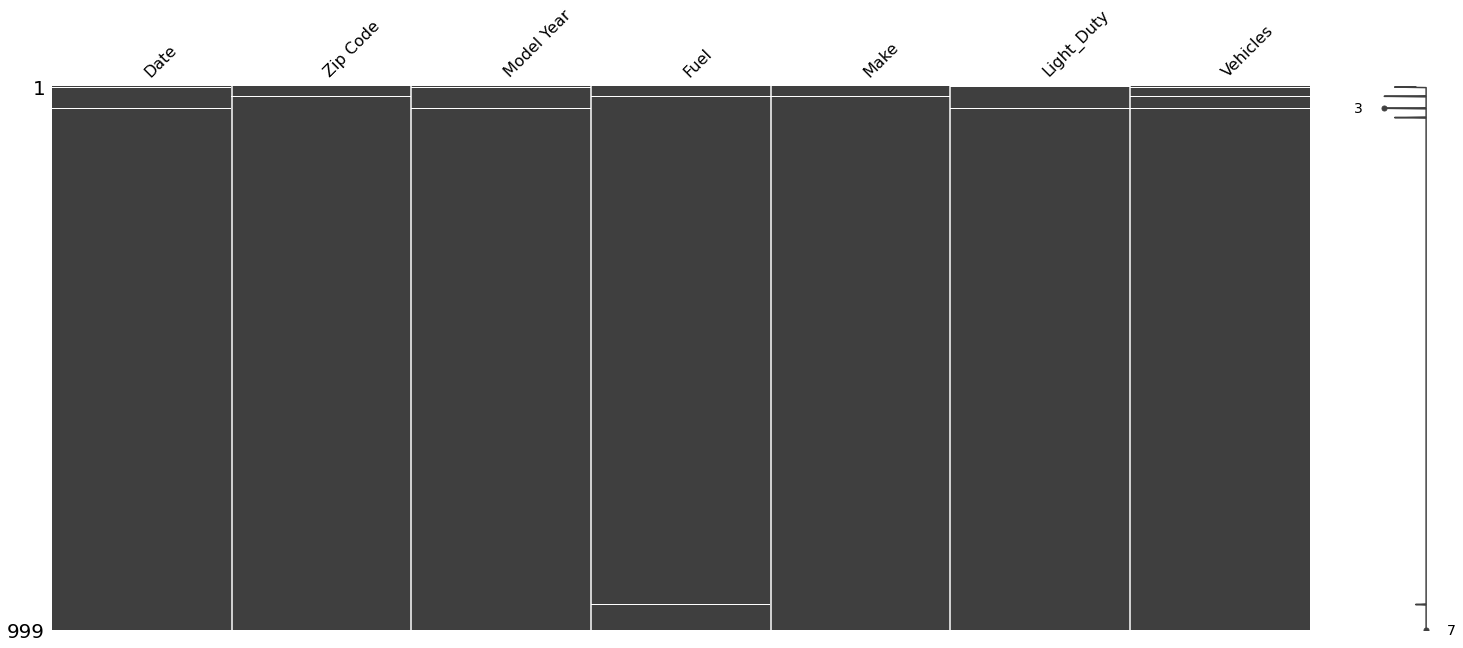

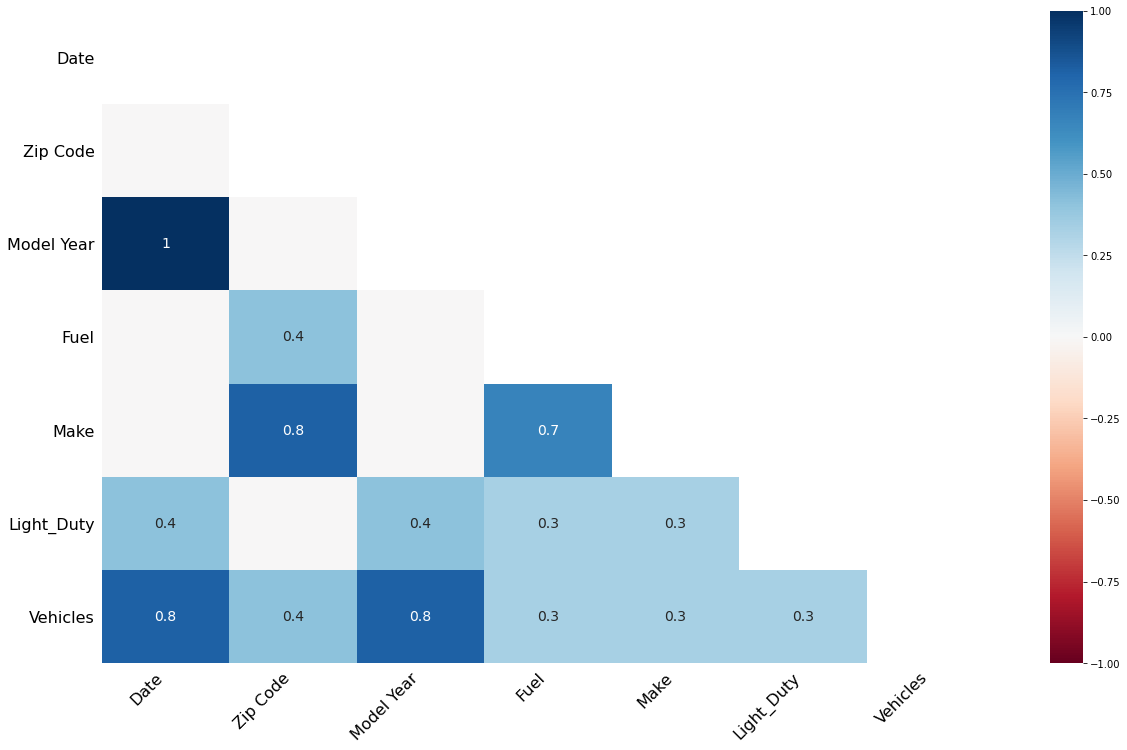

In [6]:
# The .info() function will display the concise summary of an dataframe.
df_transport.info()

We have 5 string objects, one datetime and one float object. 

### Summary Statistics 

In [ ]:
# We can use .describe() to see some summary statistics for the numeric fields (Vehicles)
df_transport.describe()

In [ ]:
# Describing all columns of a DataFrame of object datatype.
df_transport.describe(include=[object])

In [ ]:
# Describing all columns of a DataFrame of datetime datatype.
df_transport.describe(exclude = [np.number,object],datetime_is_numeric=True)

Let's investigate a bit more of our data by using the .groupby() function.

In [ ]:
# The .groupby() function is used for spliting the data into groups based on some criteria.
grouped_data = df_transport.groupby(['Zip Code','Model Year','Fuel','Make','Light_Duty','Vehicles'])

 # Get the first entry for each month.
df_transport.groupby('Fuel').first()

### Checking for Missing Values

Missing values adversely impact data quality, as they can lead the machine learning model to make inaccurate inferences about the data. Missing values can be the result of numerous factors, e.g. "bits" lost during streaming transmission, data entry, or perhaps a user forgot to fill in a field.  Note that Pandas recognizes both empty cells and “NaN” types as missing values. 

#### Let's show the null values for all features in the DataFrame.

In [ ]:
df_transport.isnull().sum()

To see a sampling of which values are missing, enter the feature column name.  You'll notice that "False" and "True" correpond to the presence or abscence of a value by index number.

In [ ]:
print(df_transport[df_transport['Date'].isnull()])
print(df_transport[~df_transport['Date'].notna()])

### What can we deduce about the data at this point?


# Let's summarize our data by row, column, features, unique, and missing values.


In [ ]:
# In Python shape() is used in pandas to give the number of rows/columns.
# The number of rows is given by .shape[0]. The number of columns is given by .shape[1].
# Thus, shape() consists of an array having two arguments -- rows and columns
print ("Rows     : " ,df_transport.shape[0])
print ("Columns  : " ,df_transport.shape[1])
print ("\nFeatures : \n" ,df_transport.columns.tolist())
print ("\nUnique values :  \n",df_transport.nunique())
print ("\nMissing values :  ", df_transport.isnull().sum().values.sum())


In [ ]:
df_transport['Zip Code'].value_counts().reset_index(name='Zip Count').rename(columns={'index':'Zip Code'})

Let's see the data again -- this time the last five rows in the dataset.

In [ ]:
# Output the last five rows in the dataset.
df_transport.tail()

### What Are Our Data Quality Issues?

1. **Data Quality Issue #1**:  
> **Missing Values**:
Each feature column has multiple missing values.  In fact, we have a total of 18 missing values.
  
2. **Data Quality Issue #2**: 
> **Model Year**: We are only interested in years greater than 2006, not "<2006".
3. **Data Quality Issue #3**:  
> **Categorical Columns**:  The feature column "Light_Duty" is categorical and has a "Yes/No" choice.  We cannot feed values like this into a machine learning model.  In addition, we need to "one-hot encode the remaining "string"/"object" columns.
4. **Data Quality Issue #4**:  
> **Temporal Features**:  How do we handle year, month, and day?


#### Data Quality Issue #1:  
##### Resolving Missing Values

Most algorithms do not accept missing values. 

One option is to "drop all the rows" with missing values.  

Lets explore other options.

For numeric columns, we can use  "mean", "mode" and "median" values to fill in the missing numeric values depending on the column data.

For categorical columns, use the "mode" (or most frequent values) to fill in missing categorical values. 


Let's check again for missing values by showing how many rows contain NaN values for each feature column.

In [ ]:
# The isnull() method is used to check and manage NULL values in a data frame.

df_transport.isnull().sum()

Run the cell to apply the lambda function.

In [ ]:
# Lets replace every column value with its mode i.e. most frequent value

df_transport = df_transport.apply(lambda x:x.fillna(x.value_counts().index[0]))

Let's check again for missing values.

In [ ]:
df_transport.isnull().sum()

Now that we have Dates as a integers, let's do some additional plotting.

#### Data Quality Issue #2:  
##### Rename a Feature Column and Remove a Value.  

Our feature columns have different "capitalizations" in their names, e.g. both upper and lower "case".  In addition, there are "spaces" in some of the column names.  In addition, we are only interested in years greater than 2006, not "<2006".  

We can also resolve the "case" problem too by making all the feature column names lower case.

In [ ]:
# Let's remove all the spaces for feature columns by renaming them.

df_transport.rename(columns = { 'Date': 'date', 'Zip Code':'zipcode', 'Model Year': 'modelyear', 'Fuel': 'fuel', 'Make': 'make', 'Light_Duty': 'lightduty', 'Vehicles': 'vehicles'}, inplace = True) 

# Output the first two rows.
df_transport.head(2)

In [ ]:
# create a copy of the dataframe to avoid copy warning issues.

df = df_transport.loc[df_transport.modelyear != '<2006'].copy()

In [ ]:
# confirm that the modelyear value '<2006' has been removed by doing a value count.
df['modelyear'].value_counts(0)

#### Data Quality Issue #3:  
##### Handling Categorical Columns

The feature column "lightduty" is categorical and has a "Yes/No" choice.  We cannot feed values like this into a machine learning model.  We need to convert the binary answers from strings of yes/no to integers of 1/0.

In [ ]:
# Lets count the number of "Yes" and"No's" in the 'lightduty' feature column.
df['lightduty'].value_counts(0)

In [ ]:
# Let's convert the Yes to 1 and No to 0.
# The .apply takes a function and applies it to all values of a Pandas series (e.g. lightduty). 
df.loc[:,'lightduty'] = df['lightduty'].apply(lambda x: 0 if x=='No' else 1)
df['lightduty'].value_counts(0)

In [ ]:
# Confirm that "lightduty" has been converted.
df.head()

#### One-Hot Encoding Categorical Feature Columns

Machine learning algorithms expect input vectors and not categorical features. Specifically, they cannot handle text or string values.  Thus, it is often useful to transform categorical features into vectors.

One transformation method is to create dummy variables for our categorical features.  Dummy variables are a set of binary (0 or 1) variables that each represent a single class from a categorical feature.  We simply  encode the categorical variable as a one-hot vector, i.e. a vector where only one element is non-zero, or hot.  With one-hot encoding, a categorical feature becomes an array whose size is the number of possible choices for that feature.

In [ ]:
# Making dummy variables for categorical data with more inputs.  
data_dummy = pd.get_dummies(df[['zipcode','modelyear', 'fuel', 'make']], drop_first=True)

# Output the first five rows.
data_dummy.head()

In [ ]:
# Merging (concatenate) original data frame with 'dummy' dataframe.

df = pd.concat([df,data_dummy], axis=1)
df.head()

In [ ]:
# Dropping attributes for which we made dummy variables.  Let's also drop the Date column.

df = df.drop(['date','zipcode','modelyear', 'fuel', 'make'], axis=1)


In [ ]:
# Confirm that 'zipcode','modelyear', 'fuel', and 'make' have been dropped.
df.head()

#### Data Quality Issue #4:  
##### Temporal Feature Columns

Lets parse date to create year,month and day feature columns.

In [ ]:
# Now we will parse Date into three columns that is year, month, and day.
df_transport['year'] = df_transport['Date'].dt.year
df_transport['month'] = df_transport['Date'].dt.month
df_transport['day'] = df_transport['Date'].dt.day

# The .info() function will display the concise summary of an dataframe.
df_transport.info()



In [ ]:
# Here, we are creating a new dataframe called "grouped_data" and grouping by on the column "Make"
grouped_data = df_transport.groupby(['Make'])

# Get the first entry for each month.
df_transport.groupby('month').first()

In [ ]:
# Here we will visualize our data using the figure() function in the pyplot module of matplotlib's library -- which is used to create a new figure.
plt.figure(figsize=(10,6))

# Seaborn's .jointplot() displays a relationship between 2 variables (bivariate) as well as 1D profiles (univariate) in the margins. This plot is a convenience class that wraps JointGrid.
sns.jointplot(x='month',y='Vehicles',data=df_transport)

# The title() method in matplotlib module is used to specify title of the visualization depicted and displays the title using various attributes.
plt.title('Vehicles by Month')

In [ ]:
# Let's print the unique values for "month", "day" and "year" in our dataset. 
print ('Unique values of month:',df.month.unique())
print ('Unique values of day:',df.day.unique())
print ('Unique values of year:',df.year.unique())

Now convert the month and day feature columns to meaningful representations as a way to get us thinking about changing temporal features -- as they are sometimes overlooked.  

In [ ]:
# Here we map each temporal variable onto a circle such that the lowest value for that variable appears right next to the largest value. We compute the x- and y- component of that point using the sin and cos trigonometric functions.
df['day_sin'] = np.sin(df.day*(2.*np.pi/31))
df['day_cos'] = np.cos(df.day*(2.*np.pi/31))
df['month_sin'] = np.sin((df.month-1)*(2.*np.pi/12))
df['month_cos'] = np.cos((df.month-1)*(2.*np.pi/12))

# Let's drop month, and day
# TODO 5
df = df.drop(['month','day','year'], axis=1)

In [ ]:
# scroll left to see the converted month and day coluumns.
df.tail(4)

### Conclusion

We resolved missing values, converted the Date feature column to a datetime format, renamed feature columns, removed a value from a feature column, created one-hot encoding features, and converted temporal features to meaningful representations.  